In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
pd.options.display.max_columns=100

In [3]:
norm_loc = './cheese_3_selectors_4/'
files = os.listdir(norm_loc)

data = {'c01':[],'c02':[],'c03':[],'c04':[],'c05':[],'c06':[],'c07':[],'c08':[],'c09':[],'c10':[],'c11':[],'c12':[],'c13':[],
        'm01':[],'m02':[],'m03':[],'m04':[],'m05':[],'m06':[],'m07':[],'m08':[],'m09':[],'m10':[],'m11':[],'m12':[],'m13':[],
        'p01':[],'p02':[],'p03':[],'p04':[],'p05':[],'p06':[],'p07':[],'p08':[],'p09':[],'p10':[],'p11':[],'p12':[],'p13':[],}

mapper = {1:'S4', 2:'S4', 3:'S4', 4:'S4',
          5:'S5', 6:'S5', 7:'S5', 8:'S5', 
          9:'S6', 10:'S6', 11:'S6', 12:'S6',
          13:'S20', 14:'S20', 15:'S20', 16:'S20'}

for f in files:
    f = norm_loc + f
    if f[-12] == 'm':
        compound = 'm' + f[-7:-5]
    elif f[-15] == 'p':
        compound = 'p' + f[-7:-5]
    else:
        compound = 'c'+f[-7:-5]

    data_set = pd.read_excel(f, sheetname=None, header=None) # need to change sheetname to sheet_name for newer pd! ie if V runs
    for key in data_set.keys():
        data_set[key] = data_set[key].set_index(0)
        data_set[key] = data_set[key].rename(columns=mapper)
    data[compound].append(data_set['Sheet1']) # Currently working with just the first exposure
for comp in data:  
    data[comp] = pd.concat(data[comp], axis=1)

In [3]:
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from scipy.spatial.distance import pdist, squareform, euclidean
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

(156, 300)


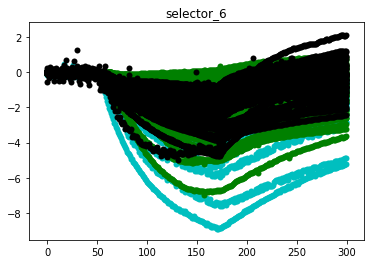

In [41]:
# just looking at selector 4:
start = 250
end = 550
select = 6
selector = []
for w in sorted(data.keys()):
    selector_data = data[w]['S'+str(select)]
    selector_data = selector_data.T.fillna(selector_data.mean(axis=1)).T 
    selector.append(selector_data)
selector = pd.concat(selector, axis=1)
selector = selector.values.T
selector = selector[:, start:end]
# selector = normalize_selector(selector)
print(selector.shape)


colors = ['c']*52 + ['g']*52 + ['k']*52
for j,c in enumerate(colors):
    y = selector[j,:]
    x = list(range(selector.shape[1]))
    plt.scatter(x,y,c=c, linewidth=0)
plt.title('selector_6')
plt.show()


In [23]:
import itertools 
import warnings
import random
warnings.filterwarnings("ignore", category=DeprecationWarning)

def get_classifier(classifier):
    if classifier == 'LR':
        return LogisticRegressionCV(cv=3, penalty='l1', solver='saga', n_jobs=-1)
    elif classifier == 'RF':
        return RandomForestClassifier(n_estimators=100, n_jobs=-1)
    elif classifier == 'KNN':
        return KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
    elif classifier == 'SVM': # using the default RBF kernel..
        return SVC() 
    elif classifier == 'GP':
        kernel = 1.0 * RBF(1.0)
        return GaussianProcessClassifier(kernel=kernel, n_jobs=-1)
    else:
        print('You did not input a valid classifier, please use one of: KNN, LR or RF')
        return
    
def get_majority_vote(vote_count_dict):
    highest_count = 0
    key_highest = None
    shared_highest = []
    for k,v in vote_count_dict.items():
        if v > highest_count:
            highest_count = v
            key_highest = k
            shared_highest = [(k,v)]
        elif v == highest_count:
            shared_highest.append((k,v))
    if len(shared_highest) > 1:
        rand_int = random.randint(0,len(shared_highest)-1)
        key_highest = shared_highest[rand_int][0]
        # get random value in 0..len(shared_highest) and use this to set the key_highest
    return key_highest


def normalize_selector(sel_data):
    max_val = sel_data.max()
    min_val = sel_data.min()
    max_min = max_val - min_val
    sel_data = (sel_data - min_val) / float(max_min)
    return sel_data

In [90]:
from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
import itertools


# getting the data into a format for the extract_features....
start = 300
end = 600
length=end-start
selectors = [4,5,6,20]
combined = []
for select in selectors:
    selector = []
    for w in sorted(data.keys()):
        selector_data = data[w]['S'+str(select)]
        selector_data = selector_data.T.fillna(selector_data.mean(axis=1)).T 
        selector.append(selector_data)
    selector = pd.concat(selector, axis=1)
    selector = selector.values.T
    selector = selector[:, start:end].reshape(-1,1)
    print(selector[:5])
    combined.append(selector)
combined = np.concatenate(combined, axis=1)
time = np.asarray([i for i in range(end-start)]*156).reshape(-1,1) # 4 (replicates in a TC) * 13 repeats *3 cheese = 36
combined = np.append(combined,time, axis=1)
combined_df = pd.DataFrame(combined, columns=['S4','S5', 'S6', 'S7', 'time'])
name_c = ['C1_{}'.format(i) for i in range(1,53)]
name_c = [[ele]*length for ele in name_c]
name_c = [j for i in name_c for j in i]
name_m = ['M1_{}'.format(i) for i in range(1,53)]
name_m = [[ele]*length for ele in name_m]
name_m = [j for i in name_m for j in i]
name_p = ['P1_{}'.format(i) for i in range(1,53)]
name_p = [[ele]*length for ele in name_p]
name_p = [j for i in name_p for j in i]
names = name_c + name_m + name_p
combined_df['id'] = names

extracted_feat = extract_features(combined_df, column_id="id", column_sort="time", column_kind=None, column_value=None)
impute(extracted_feat)

[[-0.06163056]
 [-0.11910121]
 [-0.4683998 ]
 [-0.39448321]
 [-0.50543414]]
[[-0.06479585]
 [-0.108186  ]
 [-0.11387668]
 [-0.1572667 ]
 [-0.23835619]]
[[-0.04253916]
 [-0.05911626]
 [-0.09907726]
 [-0.12734636]
 [-0.155615  ]]
[[-0.015329  ]
 [-0.01598015]
 [-0.21344543]
 [-0.21409659]
 [-0.41156187]]


Feature Extraction: 100%|██████████| 20/20 [02:23<00:00,  3.95s/it]


In [119]:
classifier = 'RF'
labels = np.array([[0,1,2]])
labels = np.repeat(labels, 52, axis=1).flatten()
# features_filtered = select_features(extracted_feat, labels)
# features_filtered.shape

data_combined_sh, labels_sh = shuffle(extracted_feat.values, labels)
x_train, x_test, y_train, y_test = train_test_split(data_combined_sh, labels_sh, test_size=0.15)
x_train_list = np.split(x_train,4, axis=1)
x_test_list = np.split(x_test,4, axis=1)
# this 794 is from the number of features each of the selectors has in the new df...might need to change
# you can get it from the commented out code at the end of this cell...'note see above....' this chunk


accuracies = []
for j in range(20):
    pred_test_combined = []
    for x_tr, x_ts in zip(x_train_list,x_test_list):
        clf = get_classifier(classifier)
        clf.fit(x_tr, y_train)
        pred_test_combined.append(clf.predict(x_ts))
    pred_test_combined = np.concatenate(pred_test_combined)
    pred_test_combined = pred_test_combined.reshape((-1,y_test.shape[0]))
    combined_vote = []
    for i in range(y_test.shape[0]):
        unique, counts = np.unique(pred_test_combined[:,i], return_counts=True)
        counts = dict(zip(unique, counts))
        majority = get_majority_vote(counts)
        combined_vote.append(majority)
    combined_vote = np.asarray(combined_vote)
    accuracies.append(accuracy_score(y_test, combined_vote))
accuracies = np.asarray(accuracies)
print(accuracies)
print('the accuracy is ', accuracies.mean(), '+/-', accuracies.std())

# note see above, stupidly called selector 20 'S7' lol...
# selectors = ['S4', 'S5', 'S6', 'S7']
# features = list(extracted_feat)
# for selector in selectors:
#     sel_list = []
#     for feat in features:
#         if selector in feat:
#             sel_list.append(feat)
#     selector_data = extracted_feat[sel_list]
#     print(selector_data.shape)




[0.95833333 0.95833333 1.         1.         1.         0.91666667
 0.95833333 0.95833333 0.91666667 0.95833333 0.95833333 1.
 0.91666667 0.95833333 1.         0.91666667 0.95833333 0.95833333
 1.         1.        ]
the accuracy is  0.9645833333333332 +/- 0.030262164679862404


In [29]:
# relaxing condition for the blocks to go together
start = 300
end = 500
classifier = 'GP'
selectors = [4,6,20]
data_combined = []
accuracies = []

for i in selectors:
    selector = []
    for w in sorted(data.keys()):
        selector_data = data[w]['S'+str(i)]
        selector_data = selector_data.T.fillna(selector_data.mean(axis=1)).T 
        selector.append(selector_data)
    selector = pd.concat(selector, axis=1)
    selector = selector.values.T
    selector = selector[:, start:end]
    data_combined.append(selector)
data_combined = np.concatenate(data_combined, axis=1)
labels = np.array([[0,1,2]])
labels = np.repeat(labels, 52, axis=1).flatten()

for j in range(20):
    data_combined_sh, labels_sh = shuffle(data_combined, labels)
    x_train, x_test, y_train, y_test = train_test_split(data_combined_sh, labels_sh, test_size=0.15)
    x_train_list = np.split(x_train,len(selectors), axis=1)
    x_test_list = np.split(x_test,len(selectors), axis=1)

    pred_test_combined = []
    for x_tr, x_ts in zip(x_train_list,x_test_list):
        clf = get_classifier(classifier)
        clf.fit(x_tr, y_train)
        pred_test_combined.append(clf.predict(x_ts))
    pred_test_combined = np.concatenate(pred_test_combined)
    pred_test_combined = pred_test_combined.reshape((-1,y_test.shape[0]))
    combined_vote = []
    for i in range(y_test.shape[0]):
        unique, counts = np.unique(pred_test_combined[:,i], return_counts=True)
        counts = dict(zip(unique, counts))
        majority = get_majority_vote(counts)
        combined_vote.append(majority)
    combined_vote = np.asarray(combined_vote)
    accuracies.append(accuracy_score(y_test, combined_vote))
accuracies = np.asarray(accuracies)
print(accuracies)
print('the accuracy is ', accuracies.mean(), '+/-', accuracies.std())



[0.75       0.79166667 0.83333333 0.95833333 0.75       0.75
 0.95833333 0.875      0.875      0.875      0.79166667 0.95833333
 0.83333333 0.79166667 0.75       0.83333333 0.83333333 0.91666667
 0.91666667 1.        ]
the accuracy is  0.8520833333333334 +/- 0.0773643526151131


In [32]:
start = 250
end = 600
classifier = 'GP'

#labels:
labels = np.array([[0,1,2]])
labels = np.repeat(labels, 52, axis=1).flatten()

range_list = list(range(labels.shape[0]))
blocks = [range_list[i:i+4] for i in range(0,labels.shape[0], 2)]
accuracies = []
for i in range(10):
    #getting indicies of the blocks to use for the test set. 
    cheese_blocks = [[0,1,2,3,4,5,6,7,8,9,10,11,12],
                     [13,14,15,16,17,18,19,20,21,22,23,24,25],
                     [26,27,28,29,30,31,32,33,34,35,36,37,38]]
    selector_masking_list = []
    for block in cheese_blocks:
        ## choosing two from each cheese to be in the test set..
        test_blocks = list(np.random.choice(block, size=2, replace=False))
        selector_masking_list += test_blocks
    ### use the values in the selector list to index the blocks list
    # block_combos = list(itertools.product(*cheese_blocks))  

    selector_drop_list = [[4,6,20]]
    for selector_list in selector_drop_list:
        pred_test_combined = []
        for i in selector_list:
            selector = []
            for w in sorted(data.keys()):
                selector_data = data[w]['S'+str(i)]
                selector_data = selector_data.T.fillna(selector_data.mean(axis=1)).T 
                selector.append(selector_data)
            selector = pd.concat(selector, axis=1)
#             selector['id'] = [1 for i in range(selector.shape[0])]
#             features = extract_features(selector, column_id='id')
            selector = selector.values.T
            selector = selector[:, start:end]
            selector = normalize_selector(selector)
            ##### MAKE SURE TO CHANGE THE NEXT LINE DEPENDING ON NUMBER CLASSES
            mask_test = []
            for ele in selector_masking_list:
                mask_test += blocks[ele]
#             print(mask_test)
            mask_train = [i for i in range(labels.shape[0]) if i not in mask_test]
#             print(mask_train)
            x_test = selector[mask_test,:]
            x_train = selector[mask_train,:]
            y_test = labels[mask_test]
            y_train = labels[mask_train]

            clf = get_classifier(classifier)
            x_train, y_train = shuffle(x_train, y_train)
            clf.fit(x_train, y_train)
            pred_test_combined.append(clf.predict(x_test)) # might be better to work with probablilites... predict_proba
        pred_test_combined = np.concatenate(pred_test_combined)
        pred_test_combined = pred_test_combined.reshape((-1,y_test.shape[0]))
        combined_vote = []
        for i in range(y_test.shape[0]):
            unique, counts = np.unique(pred_test_combined[:,i], return_counts=True)
            counts = dict(zip(unique, counts))
            majority = get_majority_vote(counts)
            combined_vote.append(majority)
        combined_vote = np.asarray(combined_vote)
        accuracies.append(accuracy_score(y_test, combined_vote))
accuracies = np.asarray(accuracies)
print(accuracies)
print('the accuracy is ', accuracies.mean(), '+/-', accuracies.std())



[0.79166667 0.79166667 0.70833333 0.875      0.70833333 0.58333333
 0.70833333 0.70833333 0.625      0.79166667]
the accuracy is  0.7291666666666667 +/- 0.08175590362645241


In [33]:
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial.distance import squareform

def indiv_sel_avg_all_to_all_dist(sel_mat, classes):
    sample_num = sel_mat.shape[0]
    class_mat_list = np.split(sel_mat, classes, axis=0)
    all_dists = []
    seen = []
    for int_1, class_mat_1 in enumerate(class_mat_list):
        for int_2, class_mat_2 in enumerate(class_mat_list):
            if int_1 == int_2:
                continue
            if (int_1,int_2) in seen or (int_2,int_1) in seen:
                continue
            seen.append((int_1, int_2))
            distances = euclidean_distances(class_mat_1, class_mat_2)
            mean = distances.mean()
            all_dists.append(mean)
    all_distances = np.asarray(all_dists)
    return all_distances.sum()

def internal_class_dissim(sel_mat, classes):
    sample_num = sel_mat.shape[0]
    class_mat_list = np.split(sel_mat, classes, axis=0)
    class_distances = []
    for class_mat in class_mat_list:
        distances = euclidean_distances(class_mat, class_mat)
        distances = distances.round(5)
        linear_mat = squareform(distances)
        class_distances.append((linear_mat.mean(), linear_mat.std()))
    return class_distances
        
        
def avg_all_to_all_dist(m1, m2):
    distances = []
    for i in range(m1.shape[0]):
        for j in range(m2.shape[0]):
            distances.append(euclidean(m1[i,:], m2[j,:]))
    distances = np.asarray(distances)
    distance_mean = distances.mean()
    return distance_mean

def dist_water_and_ethanol(selector1, selector2):
    '''
    currently hardcoded for the water-ethanol datasets assuming sorted input! ie ethanol first, then water
    '''
    ethanol_dist = avg_all_to_all_dist(selector1[:12,:], selector2[:12,:])
    water_dist = avg_all_to_all_dist(selector1[12:,:], selector2[12:,:])
    return water_dist, ethanol_dist

def normalize_selector(sel_data):
    max_val = sel_data.max()
    min_val = sel_data.min()
    max_min = max_val - min_val
    sel_data = (sel_data - min_val) / float(max_min)
    return sel_data

[5.494935463354112, 7.674670065003974, 4.8512766872145905, 4.020766935085507]
[4.496112571644042, 6.578949321266968, 4.56952685520362, 3.4388948944193065]


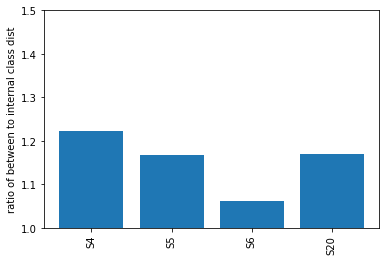

In [35]:
# calculating the dissimilarity of examples of class for each selector. 
start = 300
end = 450
classes = 3

def sel_summary(data_list): return sum([ele[0] for ele in data_list])

def data_summary(data_list):
    data_summary = []
    for d_list in data_list:
        data_summary.append(sel_summary(d_list))
    return data_summary

internal_class = []
between_class = []
labels = []
for i in [4,5, 6,20]:
    labels.append('S'+str(i))
    selector = []
    for w in sorted(data.keys()):
        selector_data = data[w]['S'+str(i)]
        selector_data = selector_data.T.fillna(selector_data.mean(axis=1)).T 
        selector.append(selector_data)
    selector = pd.concat(selector, axis=1)
    selector = selector.values.T
    selector = selector[:, start:end]
    selector = normalize_selector(selector)
    # the selector matrix is a Nxdelta_t matrix"
    # where the first half is of cheese 1 (or ethanol) and the 2nd is cheese 2 (or water)
    # OR 
    # if multiple cheeses its evenly split into three groups 
    between_class.append(indiv_sel_avg_all_to_all_dist(selector, classes))  
    internal_class.append(internal_class_dissim(selector, classes))
print(between_class)
internal_class = data_summary(internal_class)
print(internal_class)
ratio = np.divide(between_class,internal_class)
# print(summary, between_class)
ind = range(ratio.shape[0])
fig, ax = plt.subplots()
ax.set_xticks(ind)
ax.set_ylim([1,1.5])
ax.set_xticklabels(labels, rotation=90)
ax.set_ylabel('ratio of between to internal class dist')
plt.bar(ind,ratio)
plt.show()

#     sel_mean, sel_std = indiv_sel_avg_all_to_all_dist(selector)
#     all_data.append(('selector_{}'.format(i), sel_mean, sel_std))